# Pytorch try

In [1]:
# Dasha's path
import os

data_path = (r'C:\Users\darja\Documents\TuE\elastix-5.0.1-win64\TrainingData')
elastix_path = os.path.join(r'C:\Users\darja\Documents\TuE\elastix-5.0.1-win64\elastix-5.0.1-win64\elastix.exe')
transformix_path = os.path.join(r'C:\Users\darja\Documents\TuE\elastix-5.0.1-win64\elastix-5.0.1-win64\transformix.exe')

slice = 86 # insert the amount of slices we work with
patientnr = [102, 107, 108, 109, 115, 116, 117, 119, 120, 125, 127, 128, 129, 133, 135]



In [2]:
# Giulia's path
import os

data_path = (r'C:\Users\giuli\Desktop\Uni Utrecht\Capita Selecta\Project\TrainingData')
ELASTIX_PATH = os.path.join(r"C:\Users\giuli\Elastix\elastix.exe")
TRANSFORMIX_PATH = os.path.join(r"C:\Users\giuli\Elastix\transformix.exe")

slice = 86 # insert the amount of slices we work with                          
patientnr = [102, 107, 108, 109, 115, 116, 117, 119, 120, 125, 127, 128, 129, 133, 135]

nslice = 55; #slice to visualize 

ip=0; #loop through it!!!!  example of loop below. now for semplicity let's work with only 1 img at the time

mask_path=  os.path.join(data_path, 'p{}\mr_bffe.mhd'.format(patientnr[ip]))
img_path =  os.path.join(data_path, 'p{}\prostaat.mhd'.format(patientnr[ip]))
    
#for j in patientnr:
#    data_path=os.path.join(folder_path,'p{}'.format(j))  
#    print(data_path)
    

In [3]:
# First, we import PyTorch and NumPy
import torch
import numpy as np
import os
# For the augmentations
import torchvision
import random
# These two extra for evaluation.
import difflib
import scipy.spatial
# We import glob to find everything that matches a pattern
from glob import glob
# We install and import SimpleITK for image loading
# pip is the package installer for python
!pip install SimpleITK
import SimpleITK as sitk
# To show data, we import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # progressbar 

### Data Augmentations
##### Add the augmentation so that for a specific type of augmentation the same augmentation is done for both the mask and the image.

In [4]:
# functions

class transforms(): 
  def normalize(self, img, x_min, x_max): 
    max_img = torch.max(img)
    min_img = torch.min(img)
    nom = (img - min_img) * (x_max - x_min)
    denom = max_img - min_img
    denom = denom + (denom == 0) 
    return x_min + nom / denom 

  def rotate(self, img, mask, degrees): 
    """ Function to rotate both the image and mask with a random rotation in the same way.
    The degrees paramater has to be passed as a range e.g. (-18, 18).
    """
    angle = torchvision.transforms.RandomRotation.get_params(degrees)
    rotated_img = torchvision.transforms.functional.rotate(img, angle)
    rotated_mask = torchvision.transforms.functional.rotate(mask, angle)
    return rotated_img, rotated_mask

  def flip(self, img, mask): # Check if it properly works
    flipped_img = torchvision.transforms.functional.hflip(img = img) # change to .vflip for vertical flip
    flipped_mask = torchvision.transforms.functional.hflip(img = mask)
    return flipped_img, flipped_mask

  def scale(self, img, mask, range=0.2): # Check if it properly works
    """
    Function to scale both the image and the mask mask with a random range in the same way
    The range parameter is a float that will create a scaled image in the range of 1+- range
    has not yet been checked to see if it works
    """
    scale = random.randrange((1-range)*1000, (1+range)*1000)/1000
    scaled_img = torchvision.transforms.functional.affine(img=img, angle=0, translate=[0,0], shear=0, scale=scale)
    scaled_mask = torchvision.transforms.functional.affine(img=mask, angle=0, translate=[0,0], shear=0, scale=scale)
    return scaled_img, scaled_mask

  def shear(self, img, mask, degrees): # Check if it properly works.
    degree = np.random.randint(-degrees, degrees)
    sheared_img = torchvision.transforms.functional.affine(img = img, shear = [degree],
                                                         angle = 0, translate = [0,0], scale = 1)
    sheared_mask = torchvision.transforms.functional.affine(img = mask, shear = [degree],
                                                         angle = 0, translate = [0,0], scale = 1)
    return sheared_img, sheared_mask

In [5]:
class maskDataset(torch.utils.data.Dataset):
  # Datasets in Pytorch are classes of the torch.utils.data.Dataset type
  # They __must__ have at least three methods:
  # - __init__ -> Initialize the dataset, the place where you can pass parameters to it
  # - __len__ -> How many samples does your dataset represent?
  # - __getitem__ -> A function which takes a parameter i, and returns the ith sample of the dataset

  # Note that this DOES NOT perform
  # - Batching
  # - Asynchronous dataloading (for speed)
  # - Merge different datasets on the fly 
  # - shuffling the data
  # More examples like these are solved with "higher-order" methods

  # but it __might__ do:
  # - data augmentation of one sample
  # - data normalization of one sample
  # - performing on-the-fly data generation
  # - hides the nitty-gritty details of dealing with files
    
  def __init__(self, normalize = False, rotate = (False, 0) , flip = False, scale = False, shear = (False, 0)):
    
    self.slices = slice 
    self.datafolder = glob(data_path)
    print("self.datafolder is: ", self.datafolder)
    print("patientnr", patientnr)

    # Initializations for data augmentation
    self.transforms = transforms()

    # I'd suggest passing any extra parameters necessary for the transformation along with the variable as a tuple.
    # Then unpack the tuple here and use it later, when applying the augmentation. This way those parameters are not fixed inside the class.
    self.normalize = normalize
    self.rotate, self.rotation_angle = rotate
    self.flip = flip
    self.scale = scale
    self.shear, self.shear_angle = shear

  def __len__(self): # the length is the number of patients scanned at the institute. Every patient is a subfolder in the institute folder
    return len(self.datafolder) * self.slices

  # This is a helper function to avoid repeating the same SimpleITK function calls to load the images
  # It loads the Nifti files, gets a correctly spaced NumPy array, and creates a tensor
  def read_image(self, path):
    img = sitk.ReadImage(path)
    img_as_numpy = sitk.GetArrayFromImage(img).astype('float') # the default type is uint16, which trips up PyTorch so we convert to float
    img_as_tensor = torch.from_numpy(img_as_numpy)
    return img_as_tensor

  def __getitem__(self, i): # return the ith sample of the dataset, note that 0 <= i < len(dataset)
    # A slice is considered a sample.
         
    # Actually load the Nifti files and create PyTorch tensors
    mask = self.read_image(mask_path)
    img = self.read_image(img_path)
  
    _, x, y = mask.size()
    train_tensor = torch.zeros((1, x, y)) # Use only one to avoid error shown.
    target_tensor = torch.zeros((1, x, y))
    
    slice_index = i % self.slices
    train_tensor[0, ...] = img[slice_index, ...]
    target_tensor[0, ...] = mask[slice_index, ...]

    # Apply normalization
    if self.normalize:
      train_tensor = self.transforms.normalize(train_tensor, 0, 1)

    # Apply data augmentation
    if self.rotate:
      train_tensor, target_tensor = self.transforms.rotate(train_tensor, target_tensor, self.rotation_angle)
    
    if self.flip:
      train_tensor, target_tensor = self.transforms.flip(train_tensor, target_tensor)
    
    if self.scale:
      train_tensor, target_tensor = self.transforms.scale(train_tensor, target_tensor)
    
    if self.shear:
      train_tensor, target_tensor = self.transforms.shear(train_tensor, target_tensor, self.shear_angle)

    # Return the samples as PyTorch tensors
    return train_tensor, target_tensor

In [6]:
##Load data

dataset = maskDataset() # Note this dataset is now already normalized. #LEAVE IT EMPTY
print(dataset.datafolder) 
len(dataset)



self.datafolder is:  ['C:\\Users\\giuli\\Desktop\\Uni Utrecht\\Capita Selecta\\Project\\TrainingData']
patientnr [102, 107, 108, 109, 115, 116, 117, 119, 120, 125, 127, 128, 129, 133, 135]
['C:\\Users\\giuli\\Desktop\\Uni Utrecht\\Capita Selecta\\Project\\TrainingData']


86

In [7]:
#Take a look at what the data looks like
train, target = dataset[nslice]
train.size()

torch.Size([1, 333, 271])

# Data Visualisation

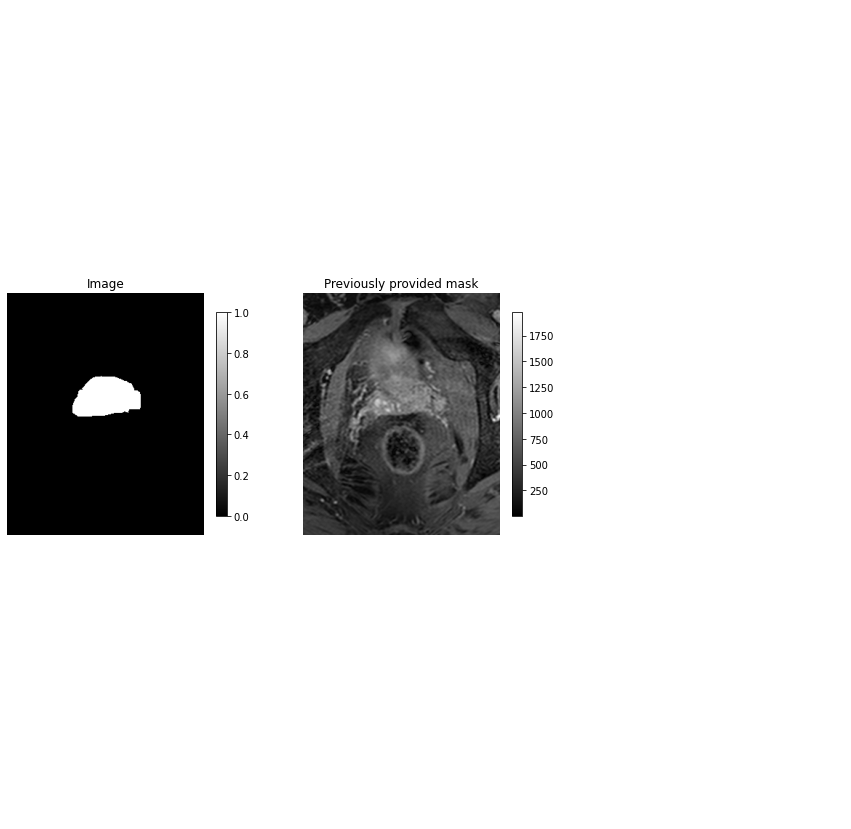

In [8]:
# create the figure
showFig = 'yes'

if showFig=='yes':
  f, ax = plt.subplots(1, 3, figsize=(15, 15))

  # turn off axis to remove ticks and such
  [a.axis('off') for a in ax]

  # Here we plot it at the actual subplot we want. We set the colormap to gray (feel free to experiment)
  img_plot = ax[0].imshow(train[0, :, :], cmap='gray') # Was one but we only working with flair for now.
  mask_plot = ax[1].imshow(target[0, :, :], cmap='gray')

  # Add titles and colorbar
  ax[0].set_title('Image')
  ax[1].set_title('Previously provided mask')

  f.colorbar(img_plot, ax=ax[0], shrink=0.25)
  f.colorbar(mask_plot, ax=ax[1], shrink=0.25)

# Model setting & training

In [9]:
import torch.nn as nn # Basic building blocks (containers, different layers ect.)

def double_conv(in_channels, out_channels): 
    return nn.Sequential( # a sequential container, elements are kept in order
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        # 3 is the size of the kernel? Padding is zero padding  
        nn.ReLU(inplace=True),
        # Activation function ReLU = applies the rectified linear unit function element wise 
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):
  # nn.Module is the base class for all neural network modules

    def __init__(self, n_class, n_channels):
      #Initialization, number of classes, number of channels
        super().__init__()
        # The U-shape         
        self.dconv_down1 = double_conv(n_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2) # a 2x2 kernel 
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [10]:
def train_epoch(model, optimizer, train_loader, lossfunction, device='cuda'):
  model.train()
  total_loss = 0
  for batch_idx, (train, target) in enumerate(tqdm(train_loader)):
    train, target = train.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(train)
    loss = lossfunction(target, output)
    total_loss += loss.item()
    loss.backward()
    optimizer.step()

  return total_loss / len(train_loader)

In [11]:
def test_epoch(model, test_loader, eval_function, device='cuda'):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for batch_idx, (train, target) in enumerate(tqdm(test_loader)):
      train, target = train.to(device), target.to(device) 
      output = model(train)
      loss = eval_function(target, output)
      total_loss += loss.item()

  return total_loss / len(test_loader)

In [12]:
def train_model(train_loader, test_loader, optimizer, lossfunction, eval_function=None, epochs=25, device='cuda'):
  if eval_function is None:
    eval_function = lossfunction
  train_losses = []
  test_losses = []
  for epoch in range(epochs):
    print('[Epoch %d / %d]' % (epoch + 1, epochs))
    train_loss = train_epoch(model, optimizer, train_loader, lossfunction, device)
    test_loss = test_epoch(model, test_loader, eval_function, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
  return train_losses, test_losses

In [13]:
import torch.optim as optim

device='cuda'
model = UNet(1,1)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

AssertionError: Torch not compiled with CUDA enabled

# Inceasing Dataset with Augmentation

In [ ]:
# Modifications on dataset should come bout here, in this and next cell.
dataset_all_transforms = maskDataset('Utrecht', rotate = (True, (-18, 18)), shear=(True, 30), scale =True, flip = True)